# NeuralTreeNet et ONNX

La conversion d'un arbre de décision au format ONNX peut créer des différences entre le modèle original et le modèle converti (voir [Issues when switching to float](https://onnx.ai/sklearn-onnx/auto_tutorial/plot_ebegin_float_double.html). Le problème vient d'un changement de type, les seuils de décisions sont arrondis au float32 le plus proche de leur valeur en float64 (double). Qu'advient-il si l'arbre de décision est converti en réseau de neurones d'abord.

L'approximation des seuils de décision ne change pas grand chose dans la majorité des cas. Cependant, il est possible que la comparaison d'une variable à un seuil de décision arrondi soit l'opposé de celle avec le seuil non arrondi. Dans ce cas, la décision suit un chemin différent dans l'arbre.

In [48]:
%matplotlib inline

## Jeu de données

On construit un jeu de donnée aléatoire.

In [49]:
import numpy

X = numpy.random.randn(10000, 10)
y = X.sum(axis=1) / X.shape[1]
X = X.astype(numpy.float64)
y = y.astype(numpy.float64)

In [50]:
middle = X.shape[0] // 2
X_train, X_test = X[:middle], X[middle:]
y_train, y_test = y[:middle], y[middle:]

## Partie scikit-learn

### Caler un arbre de décision

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=7)
tree.fit(X_train, y_train)
tree.score(X_train, y_train), tree.score(X_test, y_test)

(0.618779473874829, 0.38661000086182784)

In [52]:
from sklearn.metrics import r2_score

r2_score(y_test, tree.predict(X_test))

0.38661000086182784

La profondeur de l'arbre est insuffisante mais ce n'est pas ce qui nous intéresse ici.

### Conversion au format ONNX

In [53]:
from skl2onnx import to_onnx

onx = to_onnx(tree, X[:1].astype(numpy.float32))

In [54]:
from onnxruntime import InferenceSession

x_exp = X_test

oinf = InferenceSession(onx.SerializeToString())
expected = tree.predict(x_exp)

got = oinf.run(None, {"X": x_exp.astype(numpy.float32)})[0]
numpy.abs(got - expected).max()

np.float64(1.4748302929273112)

In [55]:
from onnx_array_api.plotting.text_plot import onnx_simple_text_plot

print(onnx_simple_text_plot(onx))

opset: domain='ai.onnx.ml' version=1
opset: domain='' version=21
input: name='X' type=dtype('float32') shape=['', 10]
TreeEnsembleRegressor(X, n_targets=1, nodes_falsenodeids=255:[128,65,34...254,0,0], nodes_featureids=255:[8,4,5...8,0,0], nodes_hitrates=255:[1.0,1.0...1.0,1.0], nodes_missing_value_tracks_true=255:[0,0,0...0,0,0], nodes_modes=255:[b'BRANCH_LEQ',b'BRANCH_LEQ'...b'LEAF',b'LEAF'], nodes_nodeids=255:[0,1,2...252,253,254], nodes_treeids=255:[0,0,0...0,0,0], nodes_truenodeids=255:[1,2,3...253,0,0], nodes_values=255:[-0.002677354495972395,-0.16326862573623657...0.0,0.0], post_transform=b'NONE', target_ids=128:[0,0,0...0,0,0], target_nodeids=128:[7,8,10...251,253,254], target_treeids=128:[0,0,0...0,0,0], target_weights=128:[-0.7625784277915955,-0.5277675986289978...0.5070647597312927,0.7122518420219421]) -> variable
output: name='variable' type=dtype('float32') shape=['', 1]


## Après la conversion en un réseau de neurones

### Conversion en un réseau de neurones

Un paramètre permet de faire varier la pente des fonctions sigmoïdes utilisées.

In [56]:
from tqdm import tqdm
from pandas import DataFrame
from mlstatpy.ml.neural_tree import NeuralTreeNet

xe = x_exp[:500]
expected = tree.predict(xe)

data = []
trees = {}
for i in tqdm([0.3, 0.4, 0.5, 0.7, 0.9, 1] + list(range(5, 61, 5))):
    root = NeuralTreeNet.create_from_tree(tree, k=i, arch="compact")
    got = root.predict(xe)[:, -1]
    me = numpy.abs(got - expected).mean()
    mx = numpy.abs(got - expected).max()
    obs = dict(k=i, max=mx, mean=me)
    data.append(obs)
    trees[i] = root

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:00<00:00, 29.67it/s]


In [57]:
df = DataFrame(data)
df

,k,max,mean
0,0.3,0.608627,0.184665
1,0.4,0.512055,0.134114
2,0.5,0.589569,0.127825
3,0.7,0.656907,0.129821
4,0.9,0.678652,0.126351
5,1.0,0.682859,0.122856
6,5.0,0.642153,0.017346
7,10.0,0.285482,0.004404
8,15.0,0.228076,0.001954
9,20.0,0.193608,0.000996


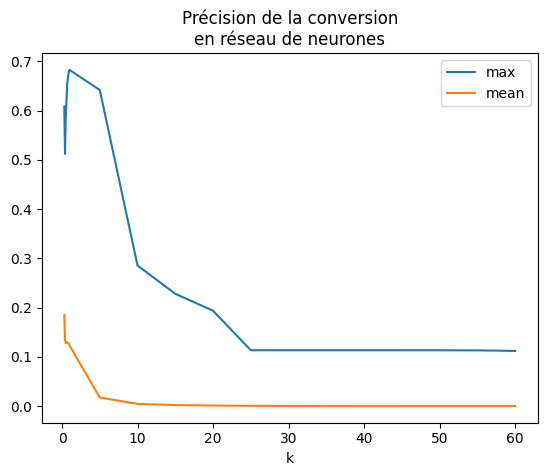

In [58]:
df.set_index("k").plot(title="Précision de la conversion\nen réseau de neurones");

L'erreur est meilleure mais il faudrait recommencer l'expérience plusieurs fois avant de pouvoir conclure afin d'obtenir un interval de confiance pour le même type de jeu de données. Ce sera pour une autre fois. Le résultat dépend du jeu de données et surtout de la proximité des seuils de décisions. Néanmoins, on calcule l'erreur sur l'ensemble de la base de test. Celle-ci a été tronquée pour aller plus vite.

In [59]:
expected = tree.predict(x_exp)
got = trees[50].predict(x_exp)[:, -1]
numpy.abs(got - expected).max(), numpy.abs(got - expected).mean()

(np.float64(0.19684418355179628), np.float64(0.0001876957464482374))

On voit que l'erreur peut-être très grande. Elle reste néanmoins plus petite que l'erreur de conversion introduite par ONNX.

### Conversion au format ONNX

On crée tout d'abord une classe qui suit l'API de scikit-learn et qui englobe l'arbre qui vient d'être créé qui sera ensuite convertit en ONNX.

In [60]:
from mlstatpy.ml.neural_tree import NeuralTreeNetRegressor

reg = NeuralTreeNetRegressor(trees[50])
onx2 = to_onnx(reg, X[:1].astype(numpy.float32))

In [61]:
print(onnx_simple_text_plot(onx2))

opset: domain='' version=21
input: name='X' type=dtype('float32') shape=['', 10]
init: name='Ma_MatMulcst' type=dtype('float32') shape=(10, 127)
init: name='Ad_Addcst' type=dtype('float32') shape=(127,)
init: name='Mu_Mulcst' type=dtype('float32') shape=(1,) -- array([4.], dtype=float32)
init: name='Ma_MatMulcst1' type=dtype('float32') shape=(127, 128)
init: name='Ad_Addcst1' type=dtype('float32') shape=(128,)
init: name='Ma_MatMulcst2' type=dtype('float32') shape=(128, 1)
init: name='Ad_Addcst2' type=dtype('float32') shape=(1,) -- array([0.], dtype=float32)
MatMul(X, Ma_MatMulcst) -> Ma_Y02
  Add(Ma_Y02, Ad_Addcst) -> Ad_C02
    Mul(Ad_C02, Mu_Mulcst) -> Mu_C01
      Sigmoid(Mu_C01) -> Si_Y01
        MatMul(Si_Y01, Ma_MatMulcst1) -> Ma_Y01
          Add(Ma_Y01, Ad_Addcst1) -> Ad_C01
            Mul(Ad_C01, Mu_Mulcst) -> Mu_C0
              Sigmoid(Mu_C0) -> Si_Y0
                MatMul(Si_Y0, Ma_MatMulcst2) -> Ma_Y0
                  Add(Ma_Y0, Ad_Addcst2) -> Ad_C0
                   

In [62]:
oinf2 = InferenceSession(
    onx2.SerializePartialToString(), providers=["CPUExecutionProvider"]
)
expected = tree.predict(x_exp)

got = oinf2.run(["variable"], {"X": x_exp.astype(numpy.float32)})[0]
numpy.abs(got - expected).max()

np.float64(1.4748302929273112)

L'erreur est la même.

## Temps de calcul

In [63]:
x_exp32 = x_exp.astype(numpy.float32)

Tout d'abord le temps de calcul pour scikit-learn.

In [64]:
%timeit tree.predict(x_exp32)

485 μs ± 15.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Le temps de calcul pour l'arbre de décision au format ONNX.

In [65]:
%timeit oinf.run(None, {'X': x_exp32})[0]

39.8 μs ± 4.37 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Et le temps de calcul pour le réseau de neurones au format ONNX.m

In [66]:
%timeit oinf2.run(None, {'X': x_exp32})[0]

1.23 ms ± 57.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Ce temps de calcul très long est attendu car le modèle contient une multiplication de matrice très grande et surtout que tous les seuils de l'arbre sont calculés pour chaque observation. Là où l'implémentation de l'arbre de décision calcule *d* seuils, la profondeur de l'arbre, la nouvelle implémentation calcule tous les seuils soit $2^d$ pour chaque feuille. Il y a $2^d$ feuilles. Même en étant sparse, on peut réduire les calculs à $d * 2^d$ ce qui fait encore beaucoup de calculs inutiles.

In [67]:
for node in trees[50].nodes:
    print(node.coef.shape, node.bias.shape)

(127, 11) (127,)
(128, 128) (128,)
(129,) ()


Cela dit, la plus grande matrice est creuse, elle peut être réduite considérablement.

In [68]:
from scipy.sparse import csr_matrix

for node in trees[50].nodes:
    csr = csr_matrix(node.coef)
    print(
        f"coef.shape={node.coef.shape}, size dense={node.coef.size}, "
        f"size sparse={csr.size}, ratio={csr.size / node.coef.size}"
    )

coef.shape=(127, 11), size dense=1397, size sparse=254, ratio=0.18181818181818182
coef.shape=(128, 128), size dense=16384, size sparse=1024, ratio=0.0625
coef.shape=(129,), size dense=129, size sparse=128, ratio=0.9922480620155039


In [69]:
r = numpy.random.randn(trees[50].nodes[1].coef.shape[0])
mat = trees[50].nodes[1].coef
%timeit mat @ r

4.47 μs ± 236 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [70]:
csr = csr_matrix(mat)
%timeit csr @ r

6.33 μs ± 289 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Ce serait beaucoup plus rapide avec une matrice sparse et d'autant plus rapide que l'arbre est profond. Le modèle ONNX se décompose comme suit.

In [71]:
print(onnx_simple_text_plot(onx2))

opset: domain='' version=21
input: name='X' type=dtype('float32') shape=['', 10]
init: name='Ma_MatMulcst' type=dtype('float32') shape=(10, 127)
init: name='Ad_Addcst' type=dtype('float32') shape=(127,)
init: name='Mu_Mulcst' type=dtype('float32') shape=(1,) -- array([4.], dtype=float32)
init: name='Ma_MatMulcst1' type=dtype('float32') shape=(127, 128)
init: name='Ad_Addcst1' type=dtype('float32') shape=(128,)
init: name='Ma_MatMulcst2' type=dtype('float32') shape=(128, 1)
init: name='Ad_Addcst2' type=dtype('float32') shape=(1,) -- array([0.], dtype=float32)
MatMul(X, Ma_MatMulcst) -> Ma_Y02
  Add(Ma_Y02, Ad_Addcst) -> Ad_C02
    Mul(Ad_C02, Mu_Mulcst) -> Mu_C01
      Sigmoid(Mu_C01) -> Si_Y01
        MatMul(Si_Y01, Ma_MatMulcst1) -> Ma_Y01
          Add(Ma_Y01, Ad_Addcst1) -> Ad_C01
            Mul(Ad_C01, Mu_Mulcst) -> Mu_C0
              Sigmoid(Mu_C0) -> Si_Y0
                MatMul(Si_Y0, Ma_MatMulcst2) -> Ma_Y0
                  Add(Ma_Y0, Ad_Addcst2) -> Ad_C0
                   

Voyons comment le temps de calcul se répartit.

In [73]:
from onnxruntime import InferenceSession, SessionOptions
from onnx_extended.tools.js_profile import js_profile_to_dataframe

sess_options = SessionOptions()
sess_options.enable_profiling = True

sess = InferenceSession(
    onx2.SerializeToString(), sess_options, providers=["CPUExecutionProvider"]
)
for i in range(43):
    sess.run(None, {"X": x_exp32})

prof = sess.end_profiling()

In [74]:
df = js_profile_to_dataframe(prof, first_it_out=True)
df

,cat,pid,tid,dur,ts,ph,name,args_op_name,op_name,args_thread_scheduling_stats,args_output_size,args_parameter_size,args_activation_size,args_node_index,args_provider,event_name,iteration,it==0
0,Session,32438,32438,511,9,X,model_loading_array,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,model_loading_array,-1,1
1,Session,32438,32438,1851,2693,X,session_initialization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,session_initialization,-1,1
2,Node,32438,32438,0,8036,X,Ma_MatMul/MatMulAddFusion/_fence_before,Gemm,Ma_MatMul/MatMulAddFusion/,NaN,NaN,NaN,NaN,NaN,NaN,fence_before,-1,1
3,Node,32438,32438,632,8043,X,Ma_MatMul/MatMulAddFusion/_kernel_time,Gemm,Ma_MatMul/MatMulAddFusion/,{'main_thread': {'thread_pool_name': 'session-...,2540000,508,200000,11,CPUExecutionProvider,kernel_time,-1,1
4,Node,32438,32438,0,8687,X,Ma_MatMul/MatMulAddFusion/_fence_after,Gemm,Ma_MatMul/MatMulAddFusion/,NaN,NaN,NaN,NaN,NaN,NaN,fence_after,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,Node,32438,32438,0,175317,X,Ma_MatMul2_fence_before,MatMul,Ma_MatMul2,NaN,NaN,NaN,NaN,NaN,NaN,fence_before,41,0
987,Node,32438,32438,77,175318,X,Ma_MatMul2_kernel_time,MatMul,Ma_MatMul2,{'main_thread': {'thread_pool_name': 'session-...,20000,0,2560000,8,CPUExecutionProvider,kernel_time,41,0
988,Node,32438,32438,0,175401,X,Ma_MatMul2_fence_after,MatMul,Ma_MatMul2,NaN,NaN,NaN,NaN,NaN,NaN,fence_after,41,0
989,Session,32438,32438,1448,173955,X,SequentialExecutor::Execute,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SequentialExecutor::Execute,42,0


In [75]:
set(df["args_provider"])

{'CPUExecutionProvider', nan}

In [76]:
dfp = df[df.args_provider == "CPUExecutionProvider"].copy()
dfp["name"] = dfp["name"].apply(lambda s: s.replace("_kernel_time", ""))
gr_dur = (
    dfp[["dur", "args_op_name", "name"]]
    .groupby(["args_op_name", "name"])
    .sum()
    .sort_values("dur")
)
gr_dur

dur
args_op_name name                               
Sigmoid      Si_Sigmoid1                    5304
             Si_Sigmoid                     5461
Mul          Mu_Mul                         8087
             Mu_Mul1                        9945
MatMul       Ma_MatMul2                     9952
Gemm         Ma_MatMul/MatMulAddFusion/    16856
             Ma_MatMul1/MatMulAddFusion/  103444

In [77]:
gr_n = (
    dfp[["dur", "args_op_name", "name"]]
    .groupby(["args_op_name", "name"])
    .count()
    .sort_values("dur")
)
gr_n = gr_n.loc[gr_dur.index, :]
gr_n

dur
args_op_name name                            
Sigmoid      Si_Sigmoid1                   43
             Si_Sigmoid                    43
Mul          Mu_Mul                        43
             Mu_Mul1                       43
MatMul       Ma_MatMul2                    43
Gemm         Ma_MatMul/MatMulAddFusion/    43
             Ma_MatMul1/MatMulAddFusion/   43

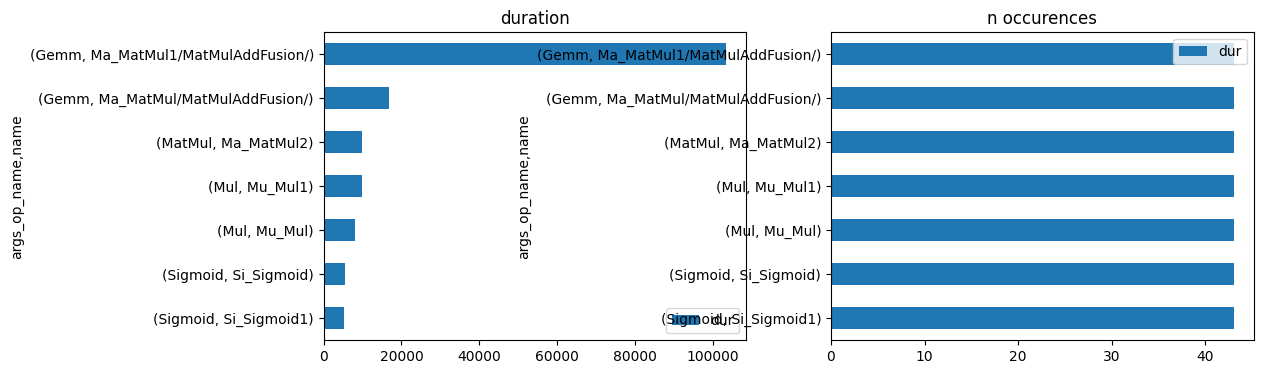

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
gr_dur.plot.barh(ax=ax[0])
gr_n.plot.barh(ax=ax[1])
ax[0].set_title("duration")
ax[1].set_title("n occurences");

onnxruntime passe principalement son temps dans un produit matriciel. On vérifie plus précisément.

In [79]:
df[(df.args_op_name == "Gemm") & (df.dur > 0)].sort_values("dur", ascending=False).head(
    n=2
).T

,541,564
cat,Node,Node
pid,32438,32438
tid,32438,32438
dur,27614,10836
ts,85208,116118
ph,X,X
name,Ma_MatMul1/MatMulAddFusion/_kernel_time,Ma_MatMul1/MatMulAddFusion/_kernel_time
args_op_name,Gemm,Gemm
op_name,Ma_MatMul1/MatMulAddFusion/,Ma_MatMul1/MatMulAddFusion/
args_thread_scheduling_stats,{'main_thread': {'thread_pool_name': 'session-...,{'main_thread': {'thread_pool_name': 'session-...


C'est un produit matriciel d'environ *5000x800* par *800x800*.

In [80]:
gr_dur / gr_dur.dur.sum()

dur
args_op_name name                                 
Sigmoid      Si_Sigmoid1                  0.033348
             Si_Sigmoid                   0.034335
Mul          Mu_Mul                       0.050846
             Mu_Mul1                      0.062528
MatMul       Ma_MatMul2                   0.062572
Gemm         Ma_MatMul/MatMulAddFusion/   0.105980
             Ma_MatMul1/MatMulAddFusion/  0.650391

In [81]:
r = (gr_dur / gr_dur.dur.sum()).dur.max()
r

np.float64(0.6503907600802269)

Il occupe 82% du temps. et d'après l'expérience précédente, son temps d'éxecution peut-être réduit par 10 en le remplaçant par une matrice sparse. Cela ne suffira pas pour accélerer le temps de calcul de ce réseau de neurones. Il est 84 ms comparé à 247 µs pour l'arbre de décision. Avec cette optimisation, il pourrait passer de :

In [82]:
t = 3.75  # ms
t * (1 - r) + r * t / 12

np.float64(1.5142817622242202)

Soit une réduction du temps de calcul. Ce n'est pas mal mais pas assez.

## Hummingbird

[hummingbird](https://github.com/microsoft/hummingbird) est une librairie qui convertit un arbre de décision en réseau de neurones. Voyons ses performances.

In [85]:
from hummingbird.ml import convert

model = convert(tree, "torch")

expected = tree.predict(x_exp)
got = model.predict(x_exp)
numpy.abs(got - expected).max(), numpy.abs(got - expected).mean()

(np.float64(2.817548150346738e-08), np.float64(4.224119546935093e-09))

Le résultat est beaucoup plus fidèle au modèle.

In [86]:
%timeit model.predict(x_exp)

872 μs ± 66.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Il reste plus lent mais beaucoup plus rapide que la solution manuelle proposée dans les précédents paragraphes. Il contient un attribut `model`.

In [87]:
from torch.nn import Module

isinstance(model.model, Module)

True

On convertit ce modèle au format ONNX.

In [88]:
import torch.onnx

x = torch.randn(x_exp.shape[0], x_exp.shape[1], requires_grad=True)
torch.onnx.export(
    model.model,
    x,
    "tree_torch.onnx",
    opset_version=15,
    input_names=["X"],
    output_names=["variable"],
    dynamic_axes={"X": {0: "batch_size"}, "variable": {0: "batch_size"}},
)

In [89]:
import onnx

onxh = onnx.load("tree_torch.onnx")

In [90]:
print(onnx_simple_text_plot(onxh, raise_exc=False))

opset: domain='' version=15
input: name='X' type=dtype('float32') shape=['batch_size', 10]
init: name='_operators.0.root_nodes' type=dtype('int64') shape=(1,) -- array([8])
init: name='_operators.0.root_biases' type=dtype('float32') shape=(1,) -- array([-0.00267735], dtype=float32)
init: name='_operators.0.tree_indices' type=dtype('int64') shape=(1,) -- array([0])
init: name='_operators.0.leaf_nodes' type=dtype('float32') shape=(128, 1)
init: name='_operators.0.nodes.0' type=dtype('int64') shape=(2,) -- array([3, 4])
init: name='_operators.0.nodes.1' type=dtype('int64') shape=(4,) -- array([4, 9, 0, 5])
init: name='_operators.0.nodes.2' type=dtype('int64') shape=(8,)
init: name='_operators.0.nodes.3' type=dtype('int64') shape=(16,)
init: name='_operators.0.nodes.4' type=dtype('int64') shape=(32,)
init: name='_operators.0.nodes.5' type=dtype('int64') shape=(64,)
init: name='_operators.0.biases.0' type=dtype('float32') shape=(2,) -- array([-0.09563538, -0.16326863], dtype=float32)
init: 

La librairie réimplémente la décision d'un arbre décision à partir d'un produit matriciel pour chaque niveau de l'arbre. Tous les seuils sont évalués. Les matrices n'ont pas besoin d'être sparses car les features nécessaires sont récupérées. Le seuil de décision est implémenté avec un test et non une sigmoïde. Ce modèle est donc identique en terme de prédiction au modèle initial.

In [93]:
oinfh = InferenceSession(onxh.SerializeToString(), providers=["CPUExecutionProvider"])
expected = tree.predict(x_exp)

got = oinfh.run(None, {"X": x_exp.astype(numpy.float32)})[0]
numpy.abs(got - expected).max()

np.float64(1.4748302929273112)

La conversion reste imparfaite également.

In [94]:
%timeit oinfh.run(None, {'X': x_exp32})[0]

1.67 ms ± 17.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Et le temps de calcul est aussi plus long.

## Apprentissage

L'idée derrière tout cela est aussi de pouvoir réestimer les coefficients du réseau de neurones une fois converti.

In [95]:
x_train = X_train[:100]
expected = tree.predict(x_train)
reg = NeuralTreeNetRegressor(trees[1], verbose=1, max_iter=10, lr=1e-4)

In [96]:
got = reg.predict(x_train)
numpy.abs(got - expected).max(), numpy.abs(got - expected).mean()

(np.float64(1.3105977468247925), np.float64(0.21366120021158772))

La différence est grande.

In [97]:
reg.fit(x_train, expected)

0/10: loss: 2.76 lr=0.0001 max(coef): 6.5 l1=0/1.5e+03 l2=0/2.5e+03
1/10: loss: 2.242 lr=9.95e-06 max(coef): 6.5 l1=8.4e+02/1.5e+03 l2=3.3e+02/2.5e+03
2/10: loss: 2.165 lr=7.05e-06 max(coef): 6.5 l1=1.7e+03/1.5e+03 l2=2e+03/2.5e+03
3/10: loss: 2.135 lr=5.76e-06 max(coef): 6.5 l1=2.6e+02/1.5e+03 l2=88/2.5e+03
4/10: loss: 2.119 lr=4.99e-06 max(coef): 6.5 l1=4.7e+02/1.5e+03 l2=2.9e+02/2.5e+03
5/10: loss: 2.106 lr=4.47e-06 max(coef): 6.5 l1=1.6e+02/1.5e+03 l2=23/2.5e+03
6/10: loss: 2.098 lr=4.08e-06 max(coef): 6.5 l1=1.9e+03/1.5e+03 l2=3.5e+03/2.5e+03
7/10: loss: 2.086 lr=3.78e-06 max(coef): 6.5 l1=9.9e+02/1.5e+03 l2=9.4e+02/2.5e+03
8/10: loss: 2.072 lr=3.53e-06 max(coef): 6.5 l1=54/1.5e+03 l2=1.9/2.5e+03
9/10: loss: 2.063 lr=3.33e-06 max(coef): 6.5 l1=6.4e+02/1.5e+03 l2=1.9e+02/2.5e+03
10/10: loss: 2.054 lr=3.16e-06 max(coef): 6.5 l1=1.2e+03/1.5e+03 l2=6.4e+02/2.5e+03


NeuralTreeNetRegressor(estimator=None, lr=0.0001, max_iter=10, verbose=1)

In [98]:
got = reg.predict(x_train)
numpy.abs(got - expected).max(), numpy.abs(got - expected).mean()

(np.float64(1.324478311165207), np.float64(0.22581473935951998))

Ca ne marche pas aussi bien que prévu. Il faudrait sans doute plusieurs itérations et jouer avec les paramètres d'apprentissage.